# Guidance

This tutorial demonstrates how to perform guidance with a pre-trained diffusion model.

In [1]:
# !git clone --depth 1 --single-branch https://github.com/openai/guided-diffusion

In [2]:
import sys
import torch

sys.path.append("guided-diffusion")

from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor
from urllib.request import urlretrieve

from azula.guidance import DPSSampler, MMPSDenoiser
from azula.plugins import adm
from azula.sample import DDIMSampler

device = "cuda"

In [3]:
_ = torch.manual_seed(0)

## Pre-trained diffusion model

In [4]:
denoiser = adm.load_model("imagenet_256x256").to(device)
denoiser = denoiser.requires_grad_(False)  # reduce memory overhead

Loading from /home/frozet/.cache/azula/hub/https.openaipublic.blob.core.windows.net.diffusion.jul-2021.256x256_diffusion_uncond.pt


In [5]:
def preprocess(x):
    return 2 * x - 1

In [6]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

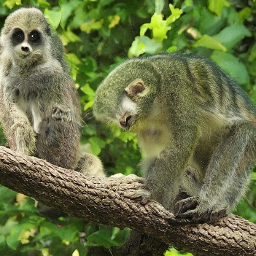

In [7]:
sampler = DDIMSampler(denoiser, steps=64).to(device)

x1 = sampler.init((1, 3, 256, 256))
x0 = sampler(x1)

to_pil_image(postprocess(x0).squeeze()).resize((256, 256), Image.NEAREST)

## Measurement

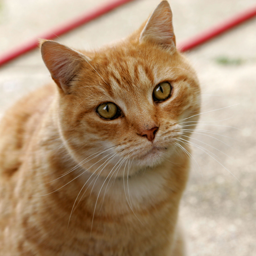

In [8]:
image, _ = urlretrieve("https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg")
image = Image.open(image).convert("RGB")
image = image.crop((0, 0, min(image.size), min(image.size))).resize((256, 256))
image

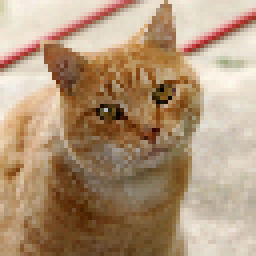

In [9]:
x = preprocess(to_tensor(image))

y = x[..., ::4, ::4]
y = y + 0.01 * torch.randn_like(y)

to_pil_image(postprocess(y)).resize(image.size, Image.NEAREST)

## Diffusion posterior sampling (DPS)

In [10]:
def A(x):
    return x[..., ::4, ::4].flatten(-3)

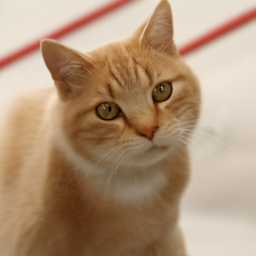

In [11]:
cond_sampler = DPSSampler(denoiser, y=y.flatten(), A=A, steps=256).to(device)

x1 = cond_sampler.init((1, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(postprocess(x0).squeeze())

## Moment matching posterior sampling (MMPS)

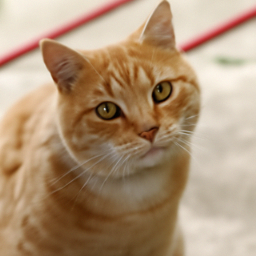

In [12]:
cond_denoiser = MMPSDenoiser(denoiser, y=y.flatten(), A=A, var_y=0.01**2, iterations=3)
cond_sampler = DDIMSampler(cond_denoiser, steps=16, eta=1.0).to(device)

x1 = cond_sampler.init((1, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(postprocess(x0).squeeze())